In [36]:
import numpy as np
import pandas as pd
from debugpy.launcher import channel
from scipy.signal import firwin, lfilter
from scipy import ndimage
import matplotlib.pyplot as plt
import seaborn as sns
import os
#os.chdir('/Users/admin/PycharmProjects/ET_eksploracja/hyperscanning-signal-analysis')
%matplotlib inline

In [37]:
!pwd

/Users/admin/Library/CloudStorage/GoogleDrive-j.zygierewicz@uw.edu.pl/Mój dysk/SYNCIN_JZ/HYPERSCANNING_SIGNAL_ANALYSIS/hyperscanning-signal-analysis/scripts


In [38]:
import sys
sys.path.append('../src')

# Functions to process position, pupil diameter, annotstions and blinks from ET

In [39]:
def process_time(ch_pos_df_0, cg_pos_df_0, ch_pupil_df_0, cg_pupil_df_0,ch_pupil_df_1, cg_pupil_df_1, ch_pupil_df_2, cg_pupil_df_2, Fs=1024):
    '''
    Create common time vector based on min and max timestamps from gaze position and pupil dataframes for child and caregiver.
    The indexes 0, 1, 2 refer to: watching movies, talk 1 and talk2 parts of the experiment.
    :param ch_pos_df: child gaze_positions_on_surface_Surface dataframe
    :param cg_pos_df: caregiver gaze_positions_on_surface_Surface dataframe
    :param ch_pupil_df: child pupil_positions dataframe
    :param cg_pupil_df: caregiver pupil_positions dataframe
    :param Fs: sampling frequency
    :return: common time
    '''
    #pupil 000: watching movies
    min_ch_pupil_0 = min(ch_pupil_df_0['pupil_timestamp'])
    max_ch_pupil_0 = max(ch_pupil_df_0['pupil_timestamp'])
    min_cg_pupil_0= min(cg_pupil_df_0['pupil_timestamp'])
    max_cg_pupil_0 = max(cg_pupil_df_0['pupil_timestamp'])
    #pupil 001: talk 1
    min_ch_pupil_1 = min(ch_pupil_df_1['pupil_timestamp'])
    max_ch_pupil_1 = max(ch_pupil_df_1['pupil_timestamp'])
    min_cg_pupil_1 = min(cg_pupil_df_1['pupil_timestamp'])
    max_cg_pupil_1 = max(cg_pupil_df_1['pupil_timestamp'])
    #pupil 002: talk 2
    min_ch_pupil_2 = min(ch_pupil_df_2['pupil_timestamp'])
    max_ch_pupil_2 = max(ch_pupil_df_2['pupil_timestamp'])
    min_cg_pupil_2 = min(cg_pupil_df_2['pupil_timestamp'])
    max_cg_pupil_2 = max(cg_pupil_df_2['pupil_timestamp'])
    #pos 000: watching movies - only during watching movies we have gaze positions on the screen
    min_cg_pos = min(cg_pos_df_0['gaze_timestamp'])
    min_ch_pos = min(ch_pos_df_0['gaze_timestamp'])
    max_ch_pos = max(ch_pos_df_0['gaze_timestamp'])
    max_cg_pos = max(cg_pos_df_0['gaze_timestamp'])
    
    
    min_t = min(min_cg_pos, min_ch_pos, min_cg_pupil_0, min_ch_pupil_0, min_cg_pupil_1, min_ch_pupil_1, min_cg_pupil_2, min_ch_pupil_2)
    max_t = max(max_cg_pos, max_ch_pos, max_cg_pupil_0, max_ch_pupil_0, max_cg_pupil_1, max_ch_pupil_1, max_cg_pupil_2, max_ch_pupil_2)
    print("min", min_t)
    print("max", max_t)
    t = np.arange(min_t, max_t, 1 / Fs)
    return t

In [40]:
def process_pos(pos_df, time):
    '''
    Process gaze position dataframe to get interpolated x and y gaze positions on common time vector.
    :param pos_df: gaze_positions_on_surface_Surface dataframe
    :param time: common time vector
    :return: interpolated x and y gaze positions
    '''
    pos_df = pos_df[pos_df['on_surf'] != False]
    x_result = pos_df.groupby('gaze_timestamp')['x_norm'].mean().reset_index()
    y_result = pos_df.groupby('gaze_timestamp')['y_norm'].mean().reset_index()
    # the camera samples with different frame rates during the experiments, and sometimes loses the eye,
    # so we need to interpolate the gaze positions to the common time vector
    x_interp = np.interp(time, x_result['gaze_timestamp'], x_result['x_norm'])
    y_interp = np.interp(time, y_result['gaze_timestamp'], y_result['y_norm'])

    return x_interp, y_interp


In [41]:
def process_pupil(pupil_df, df, who, model_confidence=0.9, median_size=10, order=351, cutoff=1, Fs=1000, plot_flag=False):
    '''
    Process pupil dataframe to get filtered 3D pupil diameter on common time vector.
    :param df: common dataframe to store the results
    :param who: 'ch' or 'cg' to indicate child or caregiver
    :param pupil_df: pupil positions dataframe
    :param time: common time for all signals
    :param model_confidence: confidence level for 3D pupil model
    :param median_size: size of median filter
    :param order: order of low pass filter 
    :param cutoff: frequency cutoff for low pass filter
    :param Fs: sampling frequency
    :param plot_flag: debug plot
    :return: array of filtered pupil diameters
    '''
    
    filtr_3d = pupil_df[pupil_df['model_confidence'] > model_confidence]
    filtr_3d = filtr_3d.copy()
    minimum =  min(filtr_3d['pupil_timestamp'])
    maximum = max(filtr_3d['pupil_timestamp'])
    mask = (df['time'] >= minimum) & (df['time'] <= maximum)
    filtr_3d['diameter3d_median'] = ndimage.median_filter(filtr_3d['diameter_3d'], size=median_size)
    diameter3d_interp = np.interp(df['time'], filtr_3d['pupil_timestamp'], filtr_3d['diameter3d_median'])
    b = firwin(order, cutoff=cutoff, fs=Fs)
    # Remember the first sample
    miu = diameter3d_interp[0]
    diameter3d_interp_filtred = lfilter(b, a=[1], x=diameter3d_interp-miu)
    delay = (len(b) - 1) // 2

    # Delay correction
    diameter3d_interp_filtred_aligned = np.roll(diameter3d_interp_filtred, -delay)
    # Fix last samples 
    diameter3d_interp_filtred_aligned[-delay:] = np.nan
    # Fix the level
    diameter3d_interp_filtred_aligned += miu

    # Debug plot
    if plot_flag:
        plt.figure()
        plt.plot(pupil_df['pupil_timestamp'], pupil_df['diameter_3d'], label='Raw')
        plt.plot(filtr_3d['pupil_timestamp'], filtr_3d['diameter3d_median'], label='Median Filtered')
        plt.plot(df['time'], diameter3d_interp, label='Interpolated')
        plt.plot(df['time'], diameter3d_interp_filtred_aligned)
        plt.show()
    col_name = f'{who}_diameter3d'
    if col_name not in df.columns:
        df[col_name] = None
        
    df.loc[mask, col_name] = diameter3d_interp_filtred_aligned[mask]
    return df[col_name]

In [42]:
def process_event_et(annotations, df, event_name=None):
    '''
    Process event annotations from eye-tracking to mark events in the common dataframe.
    Add column 'event' to df, if not present, with event names based on annotations. 
    :param annotations: dataframe with event annotations
    :param df: common dataframe to store the results
    :param event_name: optional name to assign to all events
    :return: series with event names
    '''
    annotations['type'] = annotations['label'].str.split('_').str[0]
    annotations['event'] = annotations['label'].str.split('_').str[1]

    starts = annotations[annotations['type'] == 'start'][['event', 'timestamp']]
    stops  = annotations[annotations['type'] == 'stop'][['event', 'timestamp']]

    starts = starts.rename(columns={'timestamp': 't_start'})
    stops  = stops.rename(columns={'timestamp': 't_stop'})
    if 'event' not in df.columns:
        df['event'] = None
    intervals = starts.merge(stops, on='event')
    for _, row in intervals.iterrows():
        mask = (df['time'] >= row['t_start']) & (df['time'] <= row['t_stop'])
        if event_name is None:
            df.loc[mask, 'event'] = row['event']
        else:
            df.loc[mask, 'event'] = event_name
    return df['event']   
    

In [43]:
def process_blinks(blinks,df,who):
    '''
    Process blink annotations from eye-tracking to mark blinks in the common dataframe.
    Add column '{who}_blinks' to df, if not present, with blink confidence values based on annotations. 
    :param blinks: dataframe with blink annotations
    :param df: common dataframe to store the results
    :param who: identifier for the subject (e.g., 'ch' or 'cg')
    :return: series with blink confidence values
    '''
    cols = ['start_timestamp','end_timestamp','confidence']
    blinks = blinks[cols]
    col_name = f'{who}_blinks'
    if col_name not in df.columns:
        df[col_name] = 0.0
        
    for _, row in blinks.iterrows():
        mask = (df['time'] >= row['start_timestamp']) & (df['time'] <= row['end_timestamp'])
        df.loc[mask, col_name] = row['confidence']
    return df[col_name] 

In [44]:
def reset_time_to_first_event(df):
    '''
    Reset the time column in the dataframe to start from the first event timestamp.
    We assume the events are one of the movie watching or talking parts of the experiment.
    :param df: dataframe with 'time' and 'event' columns
    :return: dataframe with reset time
    '''
    df = df.loc[df['event'].notnull()]
    first = df['time'].iloc[0]
    df['time'] = df['time'] - first
    return df

# Tests

## Hyperparametrs setting

In [45]:
Fs = 1024
order = 351 # order of the filter
cutoff = 1 # cutoff frequency of the filter in Hz   

## Loading ET data from watching movies

In [46]:
ch_pos_df_0 = pd.read_csv('../data/et_data/000/ch_gaze_positions_on_surface_Surface 1.csv')
cg_pos_df_0 = pd.read_csv('../data/et_data/000/cg_gaze_positions_on_surface_Surface 1.csv')
ch_pupil_df_0 = pd.read_csv('../data/et_data/000/ch_pupil_positions.csv')
cg_pupil_df_0 = pd.read_csv('../data/et_data/000/cg_pupil_positions.csv')
annotations_0 = pd.read_csv('../data/et_data/000/annotations.csv')
cg_blinks_0 = pd.read_csv('../data/et_data/000/cg_blinks.csv')
ch_blinks_0 = pd.read_csv('../data/et_data/000/ch_blinks.csv')

## Loading ET data from talk 1

In [47]:
ch_pupil_df_1 = pd.read_csv('../data/et_data/001/ch_pupil_positions.csv')
cg_pupil_df_1 = pd.read_csv('../data/et_data/001/cg_pupil_positions.csv')
annotations_1 = pd.read_csv('../data/et_data/001/annotations.csv')
cg_blinks_1 = pd.read_csv('../data/et_data/001/cg_blinks.csv')
ch_blinks_1 = pd.read_csv('../data/et_data/001/ch_blinks.csv')

## Loading ET data from talk 2

In [48]:
ch_pupil_df_2 = pd.read_csv('../data/et_data/002/ch_pupil_positions.csv')
cg_pupil_df_2 = pd.read_csv('../data/et_data/002/cg_pupil_positions.csv')
annotations_2 = pd.read_csv('../data/et_data/002/annotations.csv')
cg_blinks_2 = pd.read_csv('../data/et_data/002/cg_blinks.csv')
ch_blinks_2 = pd.read_csv('../data/et_data/002/ch_blinks.csv')

## Construct data frame for ET data

In [49]:
df = pd.DataFrame()

In [50]:
df['time'] = process_time(ch_pos_df_0, cg_pos_df_0, ch_pupil_df_0, cg_pupil_df_0, ch_pupil_df_1, cg_pupil_df_1, ch_pupil_df_2, cg_pupil_df_2, Fs=Fs)

min 347.531023743903
max 1056.456152707318


In [51]:
df['ch_x_interp'],df['ch_y_interp'] = process_pos(ch_pos_df_0, df['time'])
df['cg_x_interp'],df['cg_y_interp'] = process_pos(cg_pos_df_0, df['time'])

In [52]:
df['ch_diameter3d'] = process_pupil(ch_pupil_df_0, df,'ch')
df['ch_diameter3d'] = process_pupil(ch_pupil_df_1, df,'ch')
df['ch_diameter3d'] = process_pupil(ch_pupil_df_2, df,'ch')

df['cg_diameter3d'] = process_pupil(cg_pupil_df_0, df,'cg')
df['cg_diameter3d'] = process_pupil(cg_pupil_df_1, df,'cg')
df['cg_diameter3d'] = process_pupil(cg_pupil_df_2, df,'cg')

In [53]:
df['event'] = process_event_et(annotations_0, df)
df['event'] = process_event_et(annotations_1, df, 'talk1')
df['event'] = process_event_et(annotations_2, df, 'talk2')
print(df['event'].unique())

[None 'm1' 'm2' 'm3' 'talk1' 'talk2']


In [54]:
df['cg_blinks'] = process_blinks(cg_blinks_0, df,'cg')
df['cg_blinks'] = process_blinks(cg_blinks_1, df,'cg')
df['cg_blinks'] = process_blinks(cg_blinks_2, df,'cg')

df['ch_blinks'] = process_blinks(ch_blinks_0, df,'ch')
df['ch_blinks'] = process_blinks(ch_blinks_1, df,'ch')
df['ch_blinks'] = process_blinks(ch_blinks_2, df,'ch')

In [55]:
#df['dist'] = np.sqrt((df['ch_x_interp'] - df['cg_x_interp'])**2 + (df['ch_y_interp'] - df['cg_y_interp'])**2)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725940 entries, 0 to 725939
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   time           725940 non-null  float64
 1   ch_x_interp    725940 non-null  float64
 2   ch_y_interp    725940 non-null  float64
 3   cg_x_interp    725940 non-null  float64
 4   cg_y_interp    725940 non-null  float64
 5   ch_diameter3d  664326 non-null  object 
 6   cg_diameter3d  665043 non-null  object 
 7   event          551862 non-null  object 
 8   cg_blinks      725940 non-null  float64
 9   ch_blinks      725940 non-null  float64
dtypes: float64(7), object(3)
memory usage: 55.4+ MB


In [57]:
# df['ch_blinks'].value_counts()

## Connecting the ET with EEG

## Load EEG data

In [58]:
import dataloader
# creates a DataLoader class object that creates a structure described in the docs folder (data_structure_spec.md) from raw data
# data = DataLoader(, )
multimodal_data = dataloader.load_eeg_data("W_010", "../data/eeg_data/", False)


Detected events: [{'name': 'Brave', 'start': 419.9169921875, 'duration': 59.33203125}, {'name': 'Peppa', 'start': 489.482421875, 'duration': 59.630859375}, {'name': 'Incredibles', 'start': 559.3466796875, 'duration': 59.212890625}, {'name': 'Talk_1', 'start': 696.431640625, 'duration': 181.0556640625}, {'name': 'Talk_2'}]


Convert data from multimodal data to dataframe

In [59]:
channel_mapping = multimodal_data.eeg_channel_mapping
x = multimodal_data.eeg_data[channel_mapping['Fp1'],:]
d = multimodal_data.diode

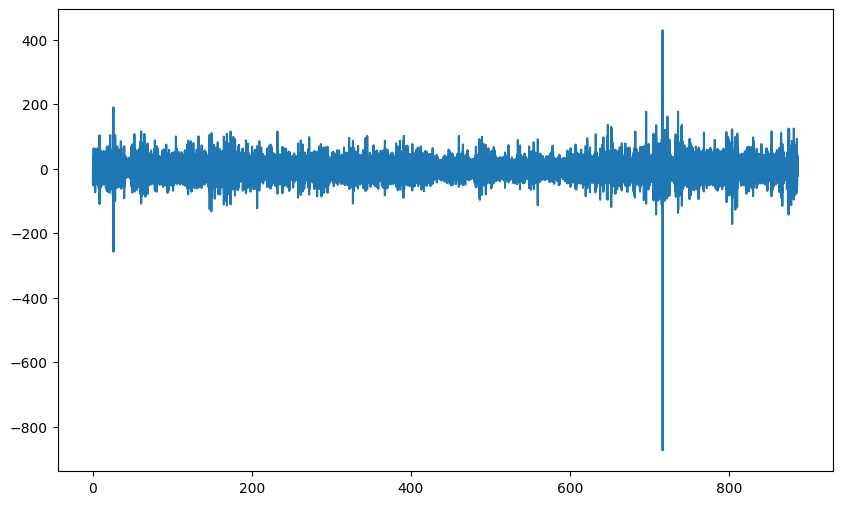

In [60]:
time = np.arange(0, len(x)/multimodal_data.eeg_fs, 1/multimodal_data.eeg_fs)
plt.figure(figsize=(10,6))
plt.plot(time, x)
plt.show()

In [61]:
df = reset_time_to_first_event(df)

/var/folders/1t/qbjskh415rz70kx6_0rww8680000gp/T/ipykernel_58874/359350440.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = df['time'] - first


In [62]:
df.loc[df['event'] == 'talk1', 'time']

288567    276.781250
288568    276.782227
288569    276.783203
288570    276.784180
288571    276.785156
             ...    
472896    456.790039
472897    456.791016
472898    456.791992
472899    456.792969
472900    456.793945
Name: time, Length: 184334, dtype: float64

In [63]:
multimodal_data.events

[{'name': 'Brave', 'start': 419.9169921875, 'duration': 59.33203125},
 {'name': 'Peppa', 'start': 489.482421875, 'duration': 59.630859375},
 {'name': 'Incredibles', 'start': 559.3466796875, 'duration': 59.212890625},
 {'name': 'Talk_1', 'start': 696.431640625, 'duration': 181.0556640625},
 {'name': 'Talk_2'}]

In [64]:
minimum = min(t['start'] for t in multimodal_data.events if 'start' in t)
minimum

419.9169921875

In [65]:
minimum = int(minimum * multimodal_data.eeg_fs)

In [66]:
df['time']

5143        0.000000
5144        0.000977
5145        0.001953
5146        0.002930
5147        0.003906
             ...    
721874    699.932617
721875    699.933594
721876    699.934570
721877    699.935547
721878    699.936523
Name: time, Length: 551862, dtype: float64

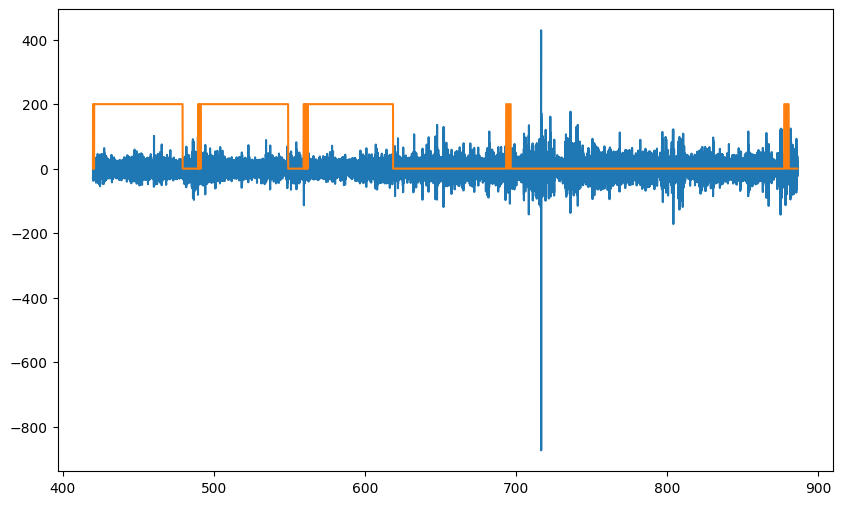

In [68]:
time = np.arange(0, len(x)/multimodal_data.eeg_fs, 1/multimodal_data.eeg_fs)
plt.figure(figsize=(10,6))
plt.plot(time[minimum:], x[minimum:])
plt.plot(time[minimum:], d[minimum:]*200)
plt.show()